In [28]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import re
import math
import sys
sys.path.insert(0, '../Code')


In [29]:
df = pd.read_csv("../datasets/titanic.csv")
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Passenger ID - To identify unique passengers<BR>
Survived - If they survived or not<BR>
P Class - The class passengers travelled in<BR>
Name - Passenger Name<BR>
Sex - Gender of Passenger<BR>
Age - Age of passenger<BR>
SibSp - Number of siblings or spouse<BR>
Parch - Parent or child<BR>
Ticket - Ticket number<BR>
Fare - Amount paid for the ticket<BR>
Cabin - Cabin of residence<BR>
Embarked - Point of embarkment<BR>


In [30]:
print("Cantidad:",  df.duplicated().sum())

Cantidad: 0


In [31]:
df.isna().sum()/df.shape[0]*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [32]:
df.drop(columns=["Cabin"], inplace=True)

In [33]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


<Axes: >

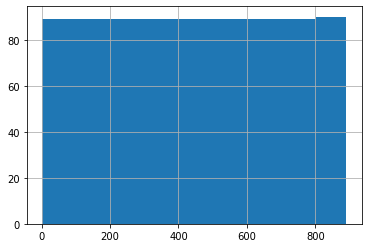

In [34]:
df["PassengerId"].hist()

In [35]:
df.drop(columns=["PassengerId"], inplace=True)

In [36]:
df["Ticket"]

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [37]:
df.drop(columns=["Ticket"], inplace=True)

In [38]:
#Muy pocos nulos en embarked, cuantas categorias son?
df["Embarked"].groupby(df["Embarked"]).count()

Embarked
C    168
Q     77
S    644
Name: Embarked, dtype: int64

In [39]:
df["Embarked"].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [40]:
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(df[["Embarked"]])
df.loc[:,"Embarked"] = imputer.transform(df[["Embarked"]])

#### Establezco tamaño de familia


In [41]:
df.loc[:,"FamSize"] = df["SibSp"] + df["Parch"] + 1
df.drop(columns=["SibSp", "Parch"], inplace=True)

In [42]:
df.count()
null_index = df[df['Age'].isnull()].index
dfKNN = df.copy()
dfSimple = df.copy()

#### Hay gente mas joven en tercera clase

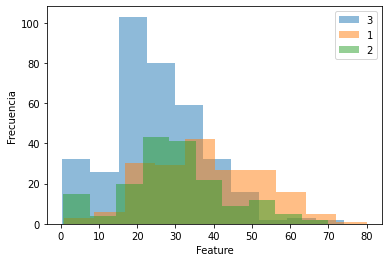

In [43]:
for clase in df['Pclass'].unique():
    plt.hist(df[df['Pclass'] == clase]['Age'], alpha=0.5, label=clase)
plt.xlabel('Feature')
plt.ylabel('Frecuencia')
plt.legend()
# Mostrar el gráfico
plt.show()

<Axes: xlabel='Pclass'>

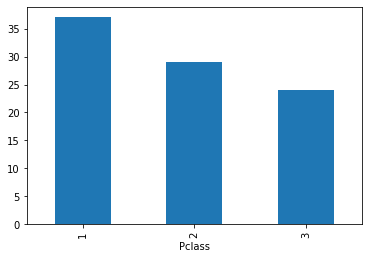

In [44]:
md = df.groupby(by=["Pclass"])["Age"].median()
md.plot(kind="bar")

In [45]:
df['FamSize'].unique()

array([ 2,  1,  5,  3,  7,  6,  4,  8, 11], dtype=int64)

#### Las familias mas grandes tienden a ser mas jovenes

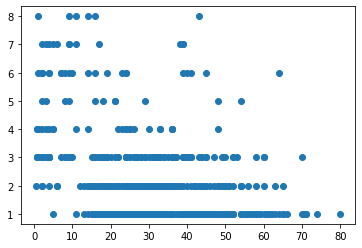

In [46]:
plt.scatter(df["Age"], df["FamSize"])

#### Veamos diferencias segun usemos KNN imputer o SimpleImputer


In [47]:
dfSimple.loc[:, "Age"] = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(dfSimple[["Age"]])

In [48]:
imputer = KNNImputer(n_neighbors=5)
imputer.fit(dfKNN[["Age", "Pclass", "FamSize"]])

KNNImputer()

In [49]:
dfKNN.loc[:, ["Age", "Pclass", "FamSize"]] = imputer.transform(dfKNN[["Age", "Pclass", "FamSize"]])#[:,0:1]

In [50]:
dfSimple.loc[null_index,["Age"]].mean() 

Age    29.699118
dtype: float64

In [51]:
dfKNN.loc[null_index,["Age"]].mean() 

Age    31.870395
dtype: float64

##### ¿Funciona mejor con simple que con KNN?

In [52]:
df = dfSimple
#df = dfKNN

#### Funcion para quitar el titulo de la persona

In [53]:
df["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [54]:
def get_title(name):
    # Un programador tiene un problema y decide usar expresiones regulares; ahora tiene dos problemas. :) :)
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

df['Title'] = df['Name'].apply(get_title)
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title'] = df['Title'].replace(['Lady', 'Master', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'No Conocido')

df.drop("Name", inplace=True, axis=1)


In [55]:
df.groupby(['Title'])['Title'].count()

Title
Miss           185
Mr             517
Mrs            126
No Conocido     63
Name: Title, dtype: int64

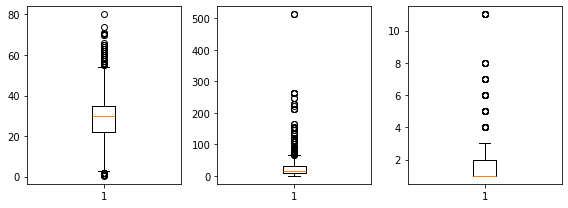

In [57]:
bxColumns = ["Age", "Fare", "FamSize"]
fig, axs = plt.subplots(1, len(bxColumns), figsize=(8, 3))
for c,i in zip(bxColumns, range(len(bxColumns))):
    axs[i].boxplot(df[c])
   
plt.tight_layout()
plt.show()

¿Excesivamente agresivo con los outliers? Posiblemente. Testear diferentes alternativas

In [58]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamSize,Title
0,0,3,male,22.0,7.2500,S,2,Mr
1,1,1,female,38.0,71.2833,C,2,Mrs
2,1,3,female,26.0,7.9250,S,1,Miss
3,1,1,female,35.0,53.1000,S,2,Mrs
4,0,3,male,35.0,8.0500,S,1,Mr


In [60]:
remove_outliers = True
if remove_outliers:
    for c in df.columns:
        if("float" in str(df.dtypes[c]) or "int" in str(df.dtypes[c])):
            Q1 = df[c].quantile(0.25)
            Q3 = df[c].quantile(0.75)
            IQR = Q3-Q1
            LI = Q1 - 1.5 * IQR
            LS = Q3 + 1.5 * IQR
            df = df[(df[c]<LS) & (df[c]>LI)]



In [61]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamSize,Title
0,0,3,male,22.000000,7.2500,S,2,Mr
2,1,3,female,26.000000,7.9250,S,1,Miss
3,1,1,female,35.000000,53.1000,S,2,Mrs
4,0,3,male,35.000000,8.0500,S,1,Mr
5,0,3,male,29.699118,8.4583,Q,1,Mr


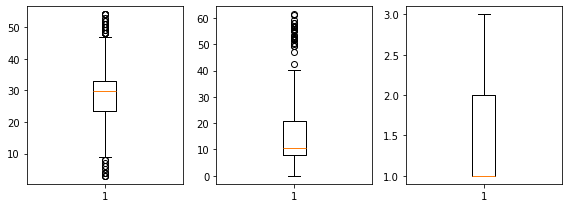

In [62]:
fig, axs = plt.subplots(1, len(bxColumns), figsize=(8, 3))
for c,i in zip(bxColumns, range(len(bxColumns))):
    axs[i].boxplot(df[c])
   
plt.tight_layout()
plt.show()

In [63]:
df.to_csv("../datasets/titanicPreprocesado.csv", index=False)

In [64]:
#Guardo copia para uso futuro
dfSinDummies = df.copy()


In [65]:
df = pd.get_dummies(df, columns=["Title"], prefix=["title"] )
df = pd.get_dummies(df, columns=["Sex", "Embarked"], prefix=["Sex", "Embarked"] ) 

In [41]:
df

,Survived,Pclass,Age,Fare,FamSize,title_Miss,title_Mr,title_Mrs,title_No Conocido,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.000000,7.2500,2,False,True,False,False,False,True,False,False,True
2,1,3,26.000000,7.9250,1,True,False,False,False,True,False,False,False,True
3,1,1,35.000000,53.1000,2,False,False,True,False,True,False,False,False,True
4,0,3,35.000000,8.0500,1,False,True,False,False,False,True,False,False,True
5,0,3,29.699118,8.4583,1,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,3,25.000000,7.0500,1,False,True,False,False,False,True,False,False,True
886,0,2,27.000000,13.0000,1,False,False,False,True,False,True,False,False,True
887,1,1,19.000000,30.0000,1,True,False,False,False,True,False,False,False,True
889,1,1,26.000000,30.0000,1,False,True,False,False,False,True,True,False,False


Hasta aca llega la clase de preprocesamiento

-------------------

In [42]:
target_column = "Survived"
predictors_columns = list(df.columns.drop(target_column))
X_train, X_test, y_train, y_test = train_test_split(df[predictors_columns], 
                                                    df[target_column], 
                                                    test_size=0.33, 
                                                    random_state=25)


In [43]:
scaler = StandardScaler()
scaler.fit(X_train)
XS_train    = scaler.transform(X_train)
XS_test     = scaler.transform(X_test)

In [44]:
#Se dice que deberiamos seleccionar 7
model = KNeighborsClassifier(n_neighbors=7)
model.fit(XS_train, y_train)
y_pred = model.predict(XS_test)
acu = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % acu)

Accuracy: 0.807
